ChEn-5310: Computational Continuum Transport Phenomena Spring 2021 UMass Lowell; Prof. V. F. de Almeida **02Apr21**

# 06a. Poisson 2D with Dirichlet Boundary Conditions
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\fvec}{\boldsymbol{\mathsf{f}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\flux}{\boldsymbol{q}}
   \newcommand{\xpoint}{\boldsymbol{x}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \DeclareMathOperator{\div}{div}
  \DeclareMathOperator{\grad}{grad}
  \newcommand{\Reals}{\mathbb{R}}
  \newcommand{\thetavec}{\boldsymbol{\theta}}
$

---

## Table of Contents<a id="toc"></a>
* [Objectives](#obj)
1. [Plotting Functions](#plotting)
<br><br>
1. [Problem Statement](#problem)
 + [Strong Form](#dbcstrong)
 + [Variational Form](#dbcweak)
 + [Dirichlet Energy](#energy)
<br><br>
1. [Problem Solution](#solution)
 + [MOOSE Application Development](#dbcapp)
 + [Code a Diffusion Term Kernel](#dbcdiff)
 + [Code a Source Term Kernel](#dbcsource)
 + [Compile and Link Application](#compile1)
 + [Input File](#dbcinput)
 + [Run Application](#dbcrun)
<br><br>   
1. [Linear Lagrange FEM Results](#dbclinearfemresults)
 + [Compute Error](#linearerror)
<br><br>    
1. [Quadratic Lagrange FEM Results](#dbcquadfemresults)
 + [Compute Error](#quaderror)
<br><br>    
1. [Diffusion Flux Postprocessing](#diffusionfluxpostpro)
 + [Auxiliary Variable](#auxvar)
 + [Use MOOSE Diffusion Flux Auxiliary Kernel](#auxdiffflux)
    - [Compute Error](#difffluxerror1)
 + [Code a Diffusion Flux Auxiliary Kernel](#auxdiffflux2)
 + [Compile and Link Application](#compile2)
    - [Compute Error](#difffluxerror2)
<br><br>   
1. [Energy Postprocessing](#energypostpro)
 + [Code the Energy Postprocessor](#postpro)
 + [Compile and Link Application](#compilelink2)
 + [Input File](#energyinput)
 + [Run Application](#runenergy)
 + [Energy Results](#energyresults)
    - [Compute Error](#energyerror)
<br><br>   
1. [Application Tree](#tree)
---

## [Objectives](#toc)<a id="obj"></a>

 + Extend the Poisson 1D problem covered in [Notebook 06](https://nbviewer.jupyter.org/github/dpploy/engy-5310/blob/main/notebooks/06-poisson-1d-dirichlet.ipynb) to 2D. Notes for the 1D problem must be thoroughly reviewed.
 + Introduce the Galerkin variational (weak) form of the Poisson 2D problem below ([OneNote notes here](https://studentuml-my.sharepoint.com/:o:/g/personal/valmor_dealmeida_uml_edu/Eib-vZHIpRlPlOMtz0Gf_asBegEFKsl9dOK4nHyDbgSeUA?e=sLu1td)).
 + <span style="color:red">Some initial code is provided in the course repository but no full source code is given out. A significant effort in programing is often necessary to learn the subject well. However the material in this course is helpful with this task. Hands-on work during lectures will try to fill in existing gap. The steps in this notebook are necessary for a basic understanding of the subject.</span>
 + You are supposed to consult the [`MOOSE source documentation`](https://mooseframework.inl.gov/source/index.html) to fill in gaps in reproducing the steps below.</span>

## [Plotting Functions](#toc)<a id="plotting"></a>

This is an auxiliary section for holding plotting functions used later.

In [1]:
'''Plot function for FEM Solution'''

def plot_solution(df, 
                  title='No Title', 
                  basis_functions_type='No basis functions type',
                  flux_basis_functions_type='No basis functions type'):
    
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.style.use('dark_background')

    (fig, ax1) = plt.subplots(1, figsize=(14, 5))

    ax1.plot(df['x'], df['u'],'r*-',label=basis_functions_type)

    ax1.set_xlabel(r'$x$ [cm]', fontsize=18)
    ax1.set_ylabel(r'$u_h(x)$ [g/cc]', fontsize=18, color='red')
    ax1.tick_params(axis='y', labelcolor='red', labelsize=14)
    ax1.tick_params(axis='x', labelsize=14)
    ax1.legend(loc='center left', fontsize=12)
    #ax1.set_ylim(0,1)
    ax1.grid(True)

    if 'diffFluxU_x' in df.columns:
        # create a twin x axis to be shared
        ax2 = ax1.twinx()

        ax2.plot(df['x'], df['diffFluxU_x'],'*-', color='yellow', label=flux_basis_functions_type)

        ax2.set_ylabel(r"$q_h(x)$ [g/cm2-s]", fontsize=16, color='yellow')
        ax2.tick_params(axis='y', labelcolor='yellow', labelsize=14)
        ax2.legend(loc='center right', fontsize=12)
        #ax2.set_ylim(0,2)
        #ax2.grid(True)

    plt.title(title, fontsize=20)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    print('')

In [2]:
'''Plot Function for Error Compared to Exact Dimensionless Solution'''

def plot_solution_error(df, fem_type='No FEM type'):
    
    from engy_5310.toolkit import engy5310_p1_exact_solution

    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.style.use('dark_background')
    
    (u_hat, _, _) = engy5310_p1_exact_solution(x_left, x_right, u_left, u_right, diff_coeff, source_s)

    L = df['x'].max() - df['x'].min()
    x_mean = (df['x'].max() + df['x'].min())/2.0
    x_hat = (df['x'] - x_mean)/L
    a_hat = u_left/source_s*diff_coeff/L**2
    b_hat = u_right/source_s*diff_coeff/L**2

    uh_hat = df['u']/source_s*diff_coeff/L**2

    plt.figure(1, figsize=(14, 5))
    
    plt.plot(x_hat, uh_hat,'r-*',label=fem_type)
    
    plt.plot(x_hat, u_hat(x_hat, a_hat, b_hat), 'x', color='yellow', label='Exact Solution')

    plt.plot(x_hat, uh_hat-u_hat(x_hat, a_hat, b_hat), 'x', color='magenta', label=r'$\hat{u}_h-\hat{u}$')
    
    plt.title('Dimensionless FEM Solution and Error', fontsize=20)
    plt.ylabel(r'$\hat{u}_h, \hat{u}$', fontsize=18)
    plt.xlabel(r'$\hat{x}$', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(loc='best',fontsize=12)
    plt.grid(True)
    plt.show()

In [3]:
'''Plot Function for Error Compared to Exact Dimensionless Solution'''

def plot_flux_error(df, fem_type='No FEM type'):
    
    from engy_5310.toolkit import engy5310_p1_exact_solution
        
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.style.use('dark_background')
    
    (_, flux_hat, _) = engy5310_p1_exact_solution(x_left, x_right, u_left, u_right, diff_coeff, source_s)

    L = df['x'].max() - df['x'].min()
    x_mean = (df['x'].max() + df['x'].min())/2.0
    x_hat = (df['x'] - x_mean)/L
    
    a_hat = u_left/source_s*diff_coeff/L**2
    b_hat = u_right/source_s*diff_coeff/L**2

    flux_h_hat = df['diffFluxU_x']/source_s/L

    plt.figure(1, figsize=(14, 5))
    
    plt.plot(x_hat, flux_h_hat, 'r-*', label=fem_type)
    
    plt.plot(x_hat, flux_hat(x_hat, a_hat, b_hat), 'x', color='yellow', label='Exact Solution')

    plt.plot(x_hat, flux_h_hat-flux_hat(x_hat, a_hat, b_hat),'x',color='magenta',label=r'$\hat{q}_h-\hat{q}$')
    
    plt.title('Dimensionless FEM Solution and Error', fontsize=20)
    plt.ylabel(r'$\hat{q}_h, \hat{q}$', fontsize=18)
    plt.xlabel(r'$\hat{x}$', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(loc='best',fontsize=12)
    plt.grid(True)
    plt.show()

## [Problem Statement](#toc)<a id="problem"></a>

The following sections describe what is referred in the literature as the one-dimensional Poisson problem with Dirichlet boundary conditions.

### [Strong Form of Problem Statement](#toc)<a id="dbcstrong"></a>

Solve the Poisson model problem. Find $u:\Omega\in\Reals^2\rightarrow\Reals$ for such that:

\begin{align*}
 -\div_\xpoint(-D\, \grad_\xpoint u) + S &= 0 \quad &\forall \quad \xpoint\in \Omega, \\
 u(\xpoint) &= u_\text{b}(\xpoint)            \quad &\forall \quad \xpoint\in \partial\Omega
\end{align*}
   
This problem has an analytical solution for certain domains $\Omega$ however this solution is not required here. The *flux*, $\flux:\Omega\rightarrow\Reals^2$, associated to the quantity $u$, is denoted $\flux := -D\,\grad u$, and it is often of interest as a derived quantity.

The value of the dependent variable is given on the boundary of the domain $\partial\Omega$. This is the extension of the *essential* boundary condition or  *Dirichlet boundary condition* to 2D.

### [Variational Form of Problem Statement](#toc)<a id="dbcweak"></a>

The Galerkin variational formulation is as follows. Find $u \in H^1\!\bigl(\Omega\bigr)$ so that 

\begin{align*}
 \int\limits_\Omega -D\, \grad_\xpoint u \cdot \grad_\xpoint v\,d\xpoint + \int\limits_\Omega S\,v(\xpoint)\,d\xpoint &= 0 \quad \forall \quad v \in H^1_0\!\bigl(\Omega\bigr), 
\end{align*}

where $H^1\!\bigl(\Omega\bigr) := \bigl\{ u:\Omega\in\Reals\rightarrow \Reals \mid \int_\Omega \grad_\xpoint u\cdot\grad_\xpoint u\,d\xpoint < \infty \bigr\}$ and 
$H^1_0\!\bigl(\Omega\bigr) := \bigl\{ v \mid v \in H^1(\Omega), v|_{\partial\Omega} = 0 \bigr\}$. Both function sets as just defined are Hilbert spaces. The function $v$ is called a test function. Because $v$ and $u$ are sought in very similar sets of functions, this variational form is called Galerkin's variational form.

The two integrals in the variational formulation are the key terms to be computed. Since the MOOSE framework performs the integration, and provides the implementation of the test function, we need to provide the integrand of the integrals, that is, the kernels. Therefore the kernels needed are:

 1. $-D\, \grad_\xpoint u \cdot \grad_\xpoint v$ ,
 1. $S\,v(\xpoint)$.
 
The kernels are to be evaluated at quadrature points provided by the MOOSE framework.

### [Dirichlet Energy](#toc)<a id="energy"></a>

It is of theoretical and practical importance to compute the associated energy that the variational form minimizes, that is the **Dirichlet total energy**:

\begin{align*}
 \Phi[u] := \int\limits_\Omega \,\frac{1}{2}\flux\cdot\flux - D\,S\,u(\xpoint) \,d\xpoint.
\end{align*}

Since this is done after the solution is computed, it is characterized as a *postprocessing* operation. In `MOOSE` this is implemented in a *Postprocessors*. First however, any derived quantity used in the integrand needs to be passed to the preprocessor for integration. Here we need to compute the local *flux*, $q$. In `MOOSE` this is done by creating an *auxiliary* variable and a corresponding *auxiliary kernel*. Therefore there are two additional components to [setup](#energypostpro):

1. Create the auxiliary variable $q=-D\,u'$,
1. Create the posprocessor for computing $\Phi$.

## [Problem Solution](#toc)<a id="solution"></a>

We need to create a MOOSE *application* with two MOOSE *kernels* and an *input* file. The ODE problem has a diffusion and a source term. Therefore a good way to proceed is to have two MOOSE kernels coded in C++ programming language. In the input file we will tell `MOOSE` to **add** the contribution of these kernels by simply listing them in a *[Kernels] block* in the input file (see below).

### [MOOSE Application Development](#toc)<a id="dbcapp"></a>

1. Make sure `MOOSE` has been installed an there was *no failed* tests.
1. `cd ~/moose`
1. `cd ..`
1. `./moose/scripts/stork.sh Engy5310P1`
1. Disregard the `github` setup
1. `cd engy5310p1`
1. `make`
1. `./run_tests`
1. `cp test/tests/kernels/simple_diffusion/simple_diffusion.i input.hit`
1. Cleanup: `rm -rf test/, unit/, doc/, scripts/, and run_tests`
1. Edit `src/main.C`
 - Replace `Engy5310P1TestApp` with `Engy5310P1App`
1. `make clean`
1. `make`
1. If all went successful then there is a executable file created named `engy5310p1-opt`.
1. This executable should be run on the command line by issuing the `bash` command:
 + `./engy5310p1-opt -i input.hit`
1. Use [`VisIt`](https://wci.llnl.gov/simulation/computer-codes/visit) or `Paraview` to visualize `test_out.e`

### [Code a Diffusion Term Kernel](#toc)<a id="dbcdiff"></a>

1. Starting from the project home directory.
1. `cd include`
1. `mkdir kernels`
1. `cd kernels`
1. Create a `DiffusionTerm.h` class interface as folows:
 + Use the `EquationTerm.h` [course template](https://github.com/dpploy/engy-5310/blob/main/moose-app-templates/EquationTerm.h), either copy from the previous link and paste into a text editor or do as follows:
 + `cp *path-to*/moose-app-templates/EquationTerm.h .`
 + `mv EquationTerm.h DiffusionTerm.h`
 + Edit the file `DiffusionTerm.h` with a text editor by replacing all instances of `EquationTerm` with `DiffusionTerm`.
 + You will need to declare a member variable named `_diffCoeff` as `Real` data type.
1. `cd ../..`
1. `cd src`
1. `mkdir kernels`
1. `cd kernels`
1. Create a `DiffusionTerm.C` class implementation as follows:
 + Use the `EquationTerm.C` [course template](https://github.com/dpploy/engy-5310/blob/main/moose-app-templates/EquationTerm.C), either copy from the previous link and paste into a text editor or do as follows:
 + `cp *path-to*/moose-app-templates/EquationTerm.C .`
 + `mv EquationTerm.C DiffusionTerm.C`
 + Edit the file `DiffusionTerm.C` with a text editor by replacing all instances of `EquationTerm` with `DiffusionTerm`.
 + You will need to program the *residual* and *Jacobian* methods. <span style="color:red">This portion of the implementation is convered in class.</span>
 + For the residual, a return value such as this is needed:
  ```c++
  Real
  DiffusionTerm::computeQpResidual()
  {
   return - _diffCoeff * _grad_u[_qp] * _grad_test[_i][_qp];
  }
  ```
 + For the Jacobian, a return value such as this is needed:
  ```c++
  Real
  DiffusionTerm::computeQpJacobian()
  {
   return - _diffCoeff * _grad_phi[_j][_qp] * _grad_test[_i][_qp];
  }
  ```

### [Code a Source Term Kernel](#toc)<a id="dbcsource"></a>

1. Starting from the project home directory.
1. `cd include`
1. `mkdir kernels`
1. Create a `SourceTerm.h` class interface following similar steps as done for the `DiffusionTerm.h` interface.
 + Use the `EquationTerm.h` course template.
 + You will need to declare a member variable named `_sourceS` as `Real` data type.
1. Create a `SourceTerm.C` class implementation likewise.
 + Use the `EquationTerm.C` course template.
 + You will need to program the *residual* and *Jacobian* methods. <span style="color:red">This portion of the implementation is covered in class.</span>
 
 + For the residual, a return value such as this is needed:
  ```c++
  Real
  SourceTerm::computeQpResidual()
  {
   return _sourceS * _test[_i][_qp];
  }
  ```
 + For the Jacobian, a return value such as this is needed:
 ```c++
 Real
 SourceTerm::computeQpJacobian()
 {
  return 0.0;
 }
 ```


### [Compile and Link Application](#toc)<a id="compile1"></a>

1. Make sure you are in the problem project:
 +  `cd ../..`
 + `pwd`
1. You should see: `..../engy5310p1`
1. Compile and link the application
 + `make`
1. If all is sucessfull you should see among other things in the screen output:
 + Linking Library `.../engy5310p1/lib/libengy5310p1-opt.la...`
 + Linking Executable `.../engy5310p1/engy5310p1-opt...`

### [Input File](#toc)<a id="dbcinput"></a>

Any line in the "blocked `MOOSE` input format information below" without a comment (any text to the righ of *#*) refers to a `MOOSE` framework parameter. Consult the documentation for further info on these parameters. All user-app parameters for this problem are described with comments below. Use the content below to create an `input.hit` input file. That is, using a text editor copy and paste the content below into a new file and save it as a `text` file format with name `input.hit`.

The *[VectorPosprocessors]* block in the `input.hit` file below, in conjuction with the *[Outputs]* block, instructs `MOOSE` to create simple plotting data in an output file for visualization of the solution.

Some additional info on `MOOSE` **Hierarchical Input Text** (HIT) syntax can be found [here](https://mooseframework.inl.gov/application_usage/input_syntax.html).
```
[Mesh]
 [1d]                                # any lower case name; this is our 1D block
  type = GeneratedMeshGenerator  
  dim = 1 
  xmin = 0 
  xmax = 25
  nx = 3 
 []
[]

[Variables]
 [u]                                 # our unknown variable to be related to below
  order = first
  family = lagrange
 []
[]

[Kernels]
 [diffusion-term]                    # our diffusion term kernel implemented in the app
  type = DiffusionTerm               # our name for the diffusion kernel C++ class
  variable = u                       # our unknown variable from the [Variables] block
  diffCoeff = 1.00000e-01            # our defined diffusion coefficient C++ variable
 []
 [source-term]                       # our source term kernel implemented in the app
  type = SourceTerm                  # our name for the source kernel C++ class
  variable = u                       # our unknown variable from the [Variables] block
  sourceS = 1.0000e-03               # our defined source constant C++ variable
 []
[]

[BCs]
 [entry]                             # our name for the left side of the boundary of the domain
  type = DirichletBC
  variable = u                       # our unknown variable from the [Variables] block
  boundary = left
  value = 3.00000e+00
 []
 [exit]                              # our name for the left side of the boundary of the domain
  type = DirichletBC
  variable = u                       # our unknown variable from the [Variables] block
  boundary = right
  value = 0.0
 []
[]

[Executioner]
 type = Steady
 solve_type = 'PJFNK'
 petsc_options_iname = '-pc_type -pc_hypre_type'
 petsc_options_value = 'hypre boomeramg'
[]

[VectorPostprocessors]
 [u]                                 # our unknown variable
  type = LineValueSampler
  execute_on = 'timestep_end final'
  variable = 'u'                     # our unknown variable from the [Variables] block
  start_point = '0 0 0'
  end_point = '25 0 0'
  num_points = 7
  sort_by = id
 []
[]

[Outputs]
 [csv]                              # our choice for data output: tabular
  type = CSV
  file_base = 'output'
  execute_on = 'final'
 []
[]

```
Save the input file in the `.../engy5310p1/` directory.

<div class="alert alert-block alert-info">
The development so far will allow you to solve the Poisson 1D problem as stated without computing the total energy. You should run the application at this point for testing and experimenting with the parameters and your implementation.
</div>

### [Run Application](#toc)<a id="dbcrun"></a>

1. In the `engy5310p1/` directory run the application with the Linux shell command:
 + `./engy5310p1-opt -i input.hit`
2. Compare your results with this notebook results below.
3. Return here to follow instructions on how to implement the calculation of the total energy.

## [Linear Lagrange FEM](#toc)<a id="dbclinearfemresults"></a>

Solve problem with parameter values:

> + a = 0 cm
> + b = 25 cm
> + A = 3 g/cc
> + B = 0 g/cc
> + D = 0.1 cm^2/s
> + S = 1e-3 g/cc-s

FEM parameters:

> + Basis Functions: First Order Lagrangian
> + num. of finite elements: 3

In [40]:
'''FEM Solution'''

x_left = 0
x_right = 25
y_bottom = -x_right/4.0
y_top = -y_bottom

u_left = 3
u_right = 0

diff_coeff = 0.1
source_s = 1e-3

qn_bottom = 0 # no draining at the bottom boundary
qn_top = 0 # no draining at the top boundary

n_felem_x = 10
n_felem_y = 2

order = 'first'
n_plot_pts = 2*n_felem_x + 1
n_plot_pts = 20

from engy_5310.toolkit import write_engy5310_p1_2d_input_file

write_engy5310_p1_2d_input_file(x_left, x_right, y_bottom=y_bottom, y_top=y_top, 
                                u_left=u_left, u_right=u_right, 
                                diff_coeff=diff_coeff, source_s=source_s, n_felem_x=n_felem_x, n_felem_y=n_felem_y, 
                                order=order, 
                                n_plot_pts=n_plot_pts)

In [41]:
'''Display MOOSE input file created'''

!cat engy5310p1/input.hit

# Engy-5310 Problem: Poisson 2D FEM
# UMass Lowell Nuclear Chemical Engineering
# Prof. Valmor F. de Almeida
# 05Apr21 11:39:08

# Parameters
xmin = 0.00000e+00
xmax = 2.50000e+01
ymin = -6.25000e+00
ymax = 6.25000e+00
diff_coeff = 1.00000e-01
source_s = 1.00000e-03

[Problem]
type = FEProblem
coord_type = XYZ
[]

[Mesh]
  [2d]
    type = GeneratedMeshGenerator
    dim = 2
    xmin = ${replace xmin}
    xmax = ${replace xmax}
    ymin = ${replace ymin}
    ymax = ${replace ymax}
    nx = 10
    ny = 2
  []
[]

[Variables]
  [u]
    order = first
    family = lagrange
  []
[]

[Kernels]
  [diffusion-term]
    type = DiffusionTerm
    variable = u     # produced quantity
    diffCoeff = ${replace diff_coeff}
  []
  [source-term]
    type = SourceTerm
    variable = u     # add to produced quantity
    sourceS = ${replace source_s}
  []
[]

[BCs]
  [east]
    type = DirichletBC
    variable = u
    boundary = left
    value = 3.00000e+00
  []
  [west]
    type = DirichletBC
    variable =

In [42]:
'''Run Engy5310P1 MOOSE App'''

!engy5310p1/engy5310p1-opt -i engy5310p1/input.hit



Framework Information:
MOOSE Version:           git commit e55311bc98 on 2021-04-01
LibMesh Version:         ed76100f41840c34c146dd0a7f1ff5410370b489
PETSc Version:           3.14.5
SLEPc Version:           3.14.2
Current Time:            Mon Apr  5 11:39:09 2021
Executable Timestamp:    Wed May  5 04:04:13 2021

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          2
  Spatial Dimension:       2
  Nodes:                   
    Total:                 33
    Local:                 33
  Elems:                   
    Total:                 20
    Local:                 20
  Num Subdomains:          1
  Num Partitions:          1

Nonlinear System:
  Num DOFs:                33
  Num Local DOFs:          33
  Variables:               "u" 
  Finite Element Types:    "LAGRANGE" 
  Approximation Orders:    "FIRST" 

Execution Information:
  Executioner:             Steady
  Solver Mode:             Pre

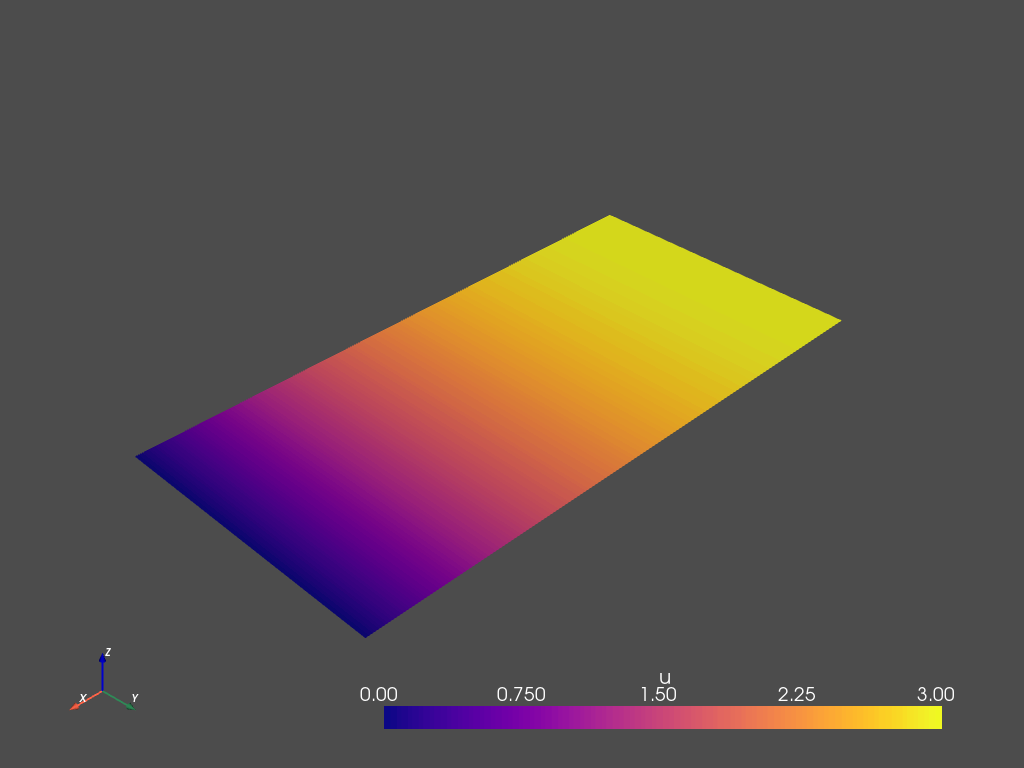

[(43.675121990743335, 31.175121990743335, 31.175121990743335),
 (12.5, 0.0, 0.0),
 (0.0, 0.0, 1.0)]

In [46]:
'''Show 2D solution'''

import pyvista as pv
import matplotlib.pyplot as plt
mesh = pv.read('engy5310p1/input_out_001_0.vtu')
cmap = plt.cm.get_cmap('plasma', 100)
mesh.plot(scalars='u', cmap=cmap)

In [45]:
help(plt.cm.get_cmap)

Help on function get_cmap in module matplotlib.cm:

get_cmap(name=None, lut=None)
    Get a colormap instance, defaulting to rc values if *name* is None.
    
    Colormaps added with :func:`register_cmap` take precedence over
    built-in colormaps.
    
    Notes
    -----
    Currently, this returns the global colormap object, which is deprecated.
    In Matplotlib 3.5, you will no longer be able to modify the global
    colormaps in-place.
    
    Parameters
    ----------
    name : `matplotlib.colors.Colormap` or str or None, default: None
        If a `.Colormap` instance, it will be returned. Otherwise, the name of
        a colormap known to Matplotlib, which will be resampled by *lut*. The
        default, None, means :rc:`image.cmap`.
    lut : int or None, default: None
        If *name* is not already a Colormap instance and *lut* is not None, the
        colormap will be resampled to have *lut* entries in the lookup table.



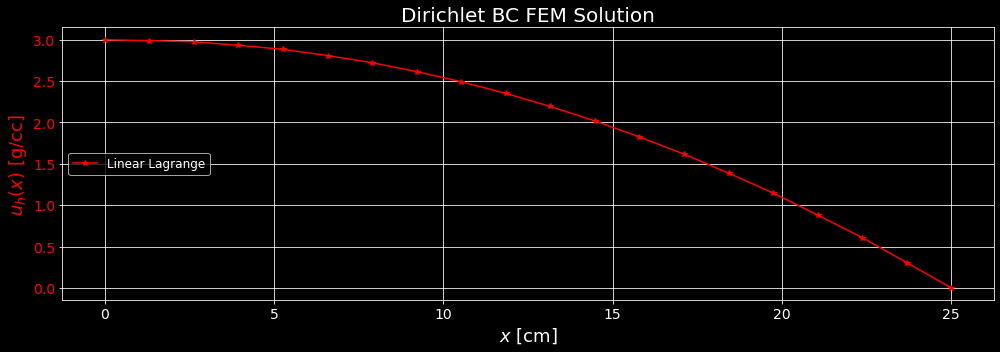

In [8]:
'''Show FEM Solution'''

import pandas as pd
df = pd.read_csv('output_x-data_0002.csv')
    
plot_solution(df, title='Dirichlet BC FEM Solution', basis_functions_type='Linear Lagrange', flux_basis_functions_type='Constant Monomial')

**Comments:**

1. The *concentration* drops from the entry value to the exit as prescribed by the boundary conditions.
1. Because of the source term the profile is quadratic.
1. Since the linear Lagrange basis functions are used with 3 finite elements, 3 linear sections approximate the solution.
1. The diffusion flux is positive everywhere, $q(x) >0$, since the normal diffusion flux on the left boundary is $q_n(a) := -q(a)$, then there is *feed* on the left boundary. On the right boundary $q_n(b) := q(b) > 0$ and there is *draining* at $x=b$.

### [FEM Error](#toc)<a id="linearerror"></a>

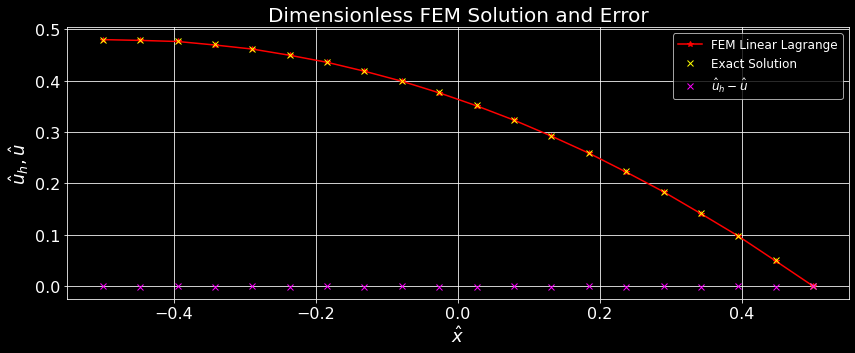

In [9]:
'''Error Compared to Exact Dimensionless Solution'''

plot_solution_error(df, fem_type='FEM Linear Lagrange')

**Comments:**

1. Error as compared to the exact dimensionless solution is zero at the boundary of the linear sections but not in between.
1. Even with linear Lagrange basis functions the error is relatively small and a proof that the use of basis functions of compact support is attractive.

## [Quadratic Lagrange FEM](#toc)<a id="dbcquadfemresults"></a>

Solve problem with parameter values:

> + a = 0 cm
> + b = 25 cm
> + A = 3 g/cc
> + B = 0 g/cc
> + D = 0.1 cm^2/s
> + S = 1e-3 g/cc-s

FEM parameters:

> + Basis Functions: Second Order Lagrangian
> + num. of finite elements: 1

The input file needs changes to select the higher order approximation:

```
[Mesh]
 [1d]                                # any lower case name; this is our 1D block
  type = GeneratedMeshGenerator  
  dim = 1 
  xmin = 0 
  xmax = 25
  nx = 1 
  elem_type = edge3                  # this goes with the second order Lagrange basis functions below
 []
[]

[Variables]
 [u]                                 # our unknown variable to be related to below
  order = second                     # MOOSE second order Lagrange basis functions
  family = lagrange
 []
[]
```

In [10]:
'''FEM Solution'''

x_left = 0
x_right = 25
y_bottom = -x_right/4.0
y_top = -y_bottom

u_left = 3
u_right = 0

diff_coeff = 0.1
source_s = 1e-3

qn_bottom = 0 # no draining at the bottom boundary
qn_top = 0 # no draining at the top boundary

diff_coeff = 0.1
source_s = 1e-3

n_felem_x = 3
n_felem_y = 2

order = 'second'
#n_plot_pts = 2*n_felem + 1
n_plot_pts = 20

from engy_5310.toolkit import write_engy5310_p1_2d_input_file

write_engy5310_p1_2d_input_file(x_left, x_right, y_bottom=y_bottom, y_top=y_top, 
                                u_left=u_left, u_right=u_right, 
                                diff_coeff=diff_coeff, source_s=source_s, n_felem_x=n_felem_x, n_felem_y=n_felem_y, 
                                order=order, 
                                n_plot_pts=n_plot_pts)

In [11]:
'''Display MOOSE input file created'''

!cat engy5310p1/input.hit

# Engy-5310 Problem: Poisson 2D FEM
# UMass Lowell Nuclear Chemical Engineering
# Prof. Valmor F. de Almeida
# 05Apr21 11:26:02

# Parameters
xmin = 0.00000e+00
xmax = 2.50000e+01
ymin = -6.25000e+00
ymax = 6.25000e+00
diff_coeff = 1.00000e-01
source_s = 1.00000e-03

[Problem]
type = FEProblem
coord_type = XYZ
[]

[Mesh]
  [2d]
    type = GeneratedMeshGenerator
    dim = 2
    xmin = ${replace xmin}
    xmax = ${replace xmax}
    ymin = ${replace ymin}
    ymax = ${replace ymax}
    nx = 3
    ny = 2
    elem_type = QUAD9
  []
[]

[Variables]
  [u]
    order = second
    family = lagrange
  []
[]

[Kernels]
  [diffusion-term]
    type = DiffusionTerm
    variable = u     # produced quantity
    diffCoeff = ${replace diff_coeff}
  []
  [source-term]
    type = SourceTerm
    variable = u     # add to produced quantity
    sourceS = ${replace source_s}
  []
[]

[BCs]
  [east]
    type = DirichletBC
    variable = u
    boundary = left
    value = 3.00000e+00
  []
  [west]
    type = Diri

In [12]:
'''Run Engy5310P1 MOOSE App'''

!engy5310p1/engy5310p1-opt -i engy5310p1/input.hit



Framework Information:
MOOSE Version:           git commit e55311bc98 on 2021-04-01
LibMesh Version:         ed76100f41840c34c146dd0a7f1ff5410370b489
PETSc Version:           3.14.5
SLEPc Version:           3.14.2
Current Time:            Mon Apr  5 11:26:04 2021
Executable Timestamp:    Wed May  5 04:04:13 2021

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          2
  Spatial Dimension:       2
  Nodes:                   
    Total:                 35
    Local:                 35
  Elems:                   
    Total:                 6
    Local:                 6
  Num Subdomains:          1
  Num Partitions:          1

Nonlinear System:
  Num DOFs:                35
  Num Local DOFs:          35
  Variables:               "u" 
  Finite Element Types:    "LAGRANGE" 
  Approximation Orders:    "SECOND" 

Execution Information:
  Executioner:             Steady
  Solver Mode:             Prec

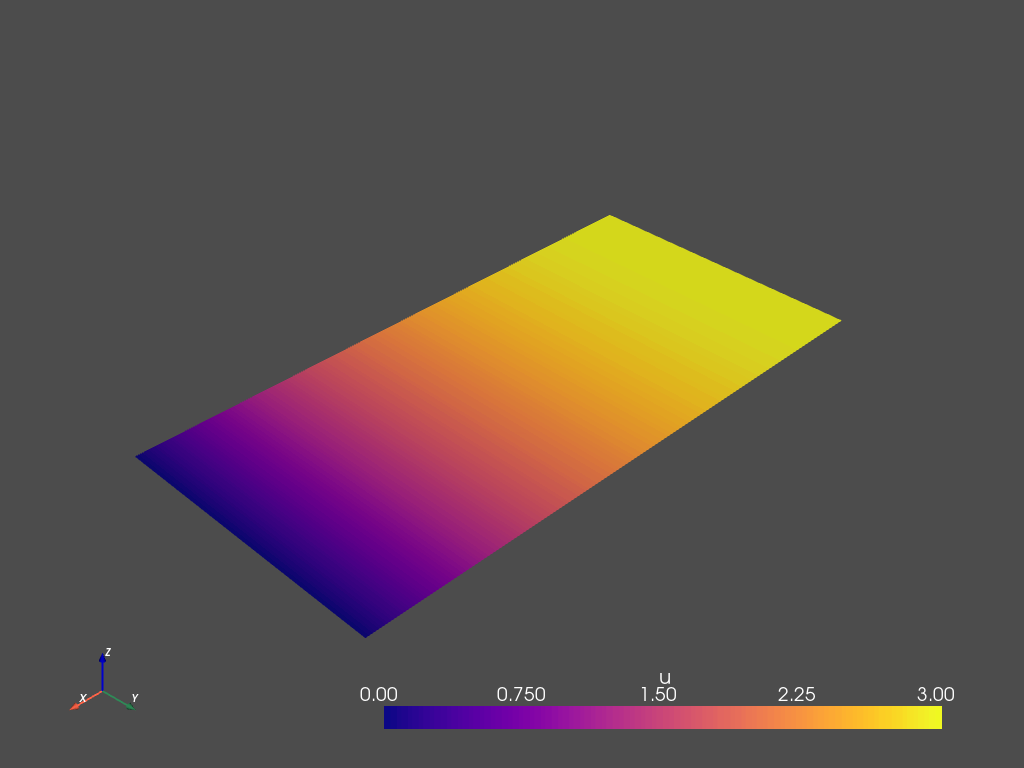

[(43.675121990743335, 31.175121990743335, 31.175121990743335),
 (12.5, 0.0, 0.0),
 (0.0, 0.0, 1.0)]

In [47]:
'''Show 2D solution'''

import pyvista as pv
import matplotlib.pyplot as plt
mesh = pv.read('engy5310p1/input_out_001_0.vtu')
cmap = plt.cm.get_cmap('plasma', 100)
mesh.plot(scalars='u', cmap=cmap)

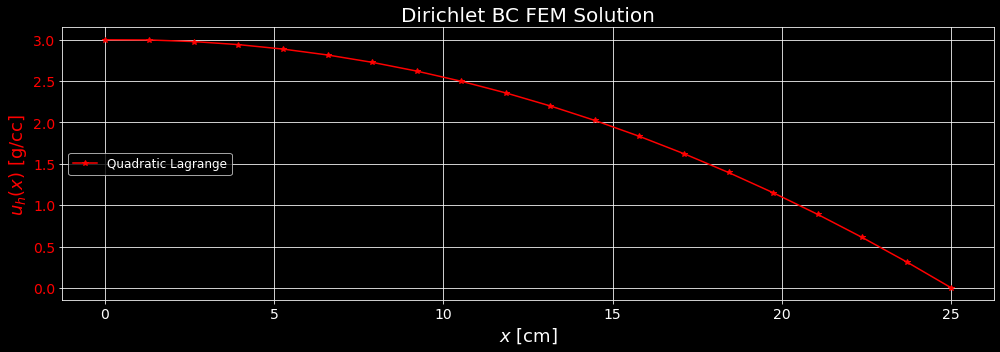

In [15]:
'''Show FEM Solution'''

import pandas as pd
df = pd.read_csv('output_x-data_0002.csv')

plot_solution(df, title='Dirichlet BC FEM Solution', basis_functions_type='Quadratic Lagrange', flux_basis_functions_type='Linear Monomial')

### [FEM Error](#toc)<a id="quaderror"></a>


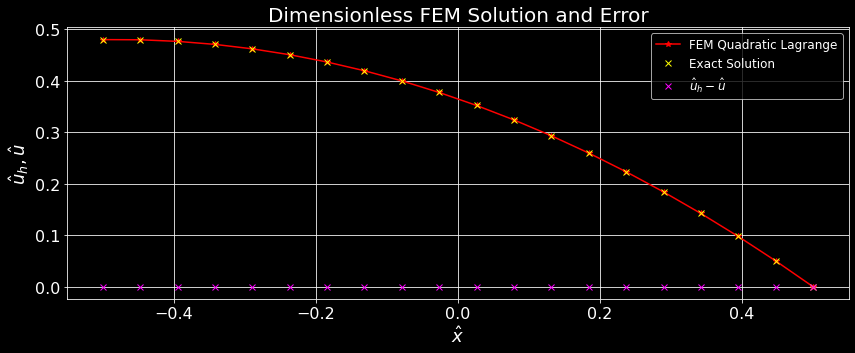

In [16]:
'''Error Compared to Exact Dimensionless Solution'''

plot_solution_error(df, fem_type='FEM Quadratic Lagrange')

**Comments:**

1. Usage of one quadratic Lagrange finite element reproduces the exact solution; as it had to.

## [Diffusion Flux Postprocessing](#toc)<a id="diffusionfluxpostpro"></a>

The diffusion flux is needed in the [Dirichlet energy](#energy) integral. This section describes the post-processing operation of calculating the flux $q$ from $u$. There are two ways to postprocess the diffusion flux as described below. In both of them, an auxiliary variables needs to be created.

### [Auxiliary Variable](#toc)<a id="auxvar"></a>

A derived variable for the difffusion flux calculated from the unknown $u$ needs to be specified in the `MOOSE` input file. The shape of the basis functions used for the diffusion flux should be consistent with the choice used for the $u$ variable. For example:

```
[Variables]
  [u]
    order = second
    family = lagrange
  []
[]

[AuxVariables]
  [diffFluxU_x]           # user-named diffusion flux component in x
    order = FIRST
    family = MONOMIAL
  []
[]
```

### [Use `MOOSE` Diffusion Flux Auxiliary Kernel](#toc)<a id="auxdiffflux"></a>

One way to compute the derivative of $u$ is to use the `MOOSE` framework `DiffusionFluxAux` kernel.
It is available for computing the flux $q$ so the flux can be computed directly using the `MOOSE` input file as follows:

```
[AuxKernels]
  [diffusion-flux-x]
    execute_on = timestep_end
    type = DiffusionFluxAux
    diffusivity = ${replace diff_coeff}
    variable = diffFluxU_x
    diffusion_variable = u
    component = x
  []
[]
```

Also, you need to output the values of flux for plotting; just add the newly created auxiliary field to the list of variables (`# output data`) on the `VectorPostprocessors` block output file, that is:

```
[VectorPostprocessors]
  [x-data]
    type = LineValueSampler
    execute_on = 'timestep_end final'
    variable = 'u diffFluxU_x'            # output data
    start_point = '${replace xmin} 0 0'
    end_point = '${replace xmax} 0 0'
    num_points = 20
    sort_by = id
  []
[]
```

In [48]:
'''FEM Solution'''

x_left = 0
x_right = 25
y_bottom = -x_right/4.0
y_top = -y_bottom

u_left = 3
u_right = 0

diff_coeff = 0.1
source_s = 1e-3

qn_bottom = 0 # no draining at the bottom boundary
qn_top = 0 # no draining at the top boundary

diff_coeff = 0.1
source_s = 1e-3

n_felem_x = 1
n_felem_y = 1

from engy_5310.toolkit import write_engy5310_p1_2d_input_file

write_engy5310_p1_2d_input_file(x_left, x_right, y_bottom=y_bottom, y_top=y_top,
                                u_left=u_left, u_right=u_right,
                                diff_coeff=diff_coeff, source_s=source_s, n_felem_x=n_felem_x, n_felem_y=n_felem_y,
                                order=order,
                                n_plot_pts=n_plot_pts, compute_diffusion_flux=True, use_moose_diffusion_flux=True)

In [49]:
'''Display MOOSE input file created'''

!cat engy5310p1/input.hit

# Engy-5310 Problem: Poisson 2D FEM
# UMass Lowell Nuclear Chemical Engineering
# Prof. Valmor F. de Almeida
# 05Apr21 11:45:51

# Parameters
xmin = 0.00000e+00
xmax = 2.50000e+01
ymin = -6.25000e+00
ymax = 6.25000e+00
diff_coeff = 1.00000e-01
source_s = 1.00000e-03

[Problem]
type = FEProblem
coord_type = XYZ
[]

[Mesh]
  [2d]
    type = GeneratedMeshGenerator
    dim = 2
    xmin = ${replace xmin}
    xmax = ${replace xmax}
    ymin = ${replace ymin}
    ymax = ${replace ymax}
    nx = 1
    ny = 1
  []
[]

[Variables]
  [u]
    order = first
    family = lagrange
  []
[]

[AuxVariables]
  [diffFluxU]
    order = CONSTANT
    family = MONOMIAL_VEC
  []
  [diffFluxU_x]
    order = CONSTANT
    family = MONOMIAL
  []
  [diffFluxU_y]
    order = CONSTANT
    family = MONOMIAL
  []
[]

[Kernels]
  [diffusion-term]
    type = DiffusionTerm
    variable = u     # produced quantity
    diffCoeff = ${replace diff_coeff}
  []
  [source-term]
    type = SourceTerm
    variable = u     # add to

In [50]:
'''Run Engy5310P1 MOOSE App'''

!engy5310p1/engy5310p1-opt -i engy5310p1/input.hit



Framework Information:
MOOSE Version:           git commit e55311bc98 on 2021-04-01
LibMesh Version:         ed76100f41840c34c146dd0a7f1ff5410370b489
PETSc Version:           3.14.5
SLEPc Version:           3.14.2
Current Time:            Mon Apr  5 11:45:52 2021
Executable Timestamp:    Wed May  5 04:04:13 2021

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          2
  Spatial Dimension:       2
  Nodes:                   
    Total:                 4
    Local:                 4
  Elems:                   
    Total:                 1
    Local:                 1
  Num Subdomains:          1
  Num Partitions:          1

Nonlinear System:
  Num DOFs:                4
  Num Local DOFs:          4
  Variables:               "u" 
  Finite Element Types:    "LAGRANGE" 
  Approximation Orders:    "FIRST" 

Auxiliary System:
  Num DOFs:                4
  Num Local DOFs:          4
  Variables:     

In [56]:
'''Show 2D solution'''

import pyvista as pv
import matplotlib.pyplot as plt
mesh = pv.read('engy5310p1/input_out_001_0.vtu')
cmap = plt.cm.get_cmap('plasma', 100)
#mesh.plot(scalars='diffFluxU_x', cmap=cmap)

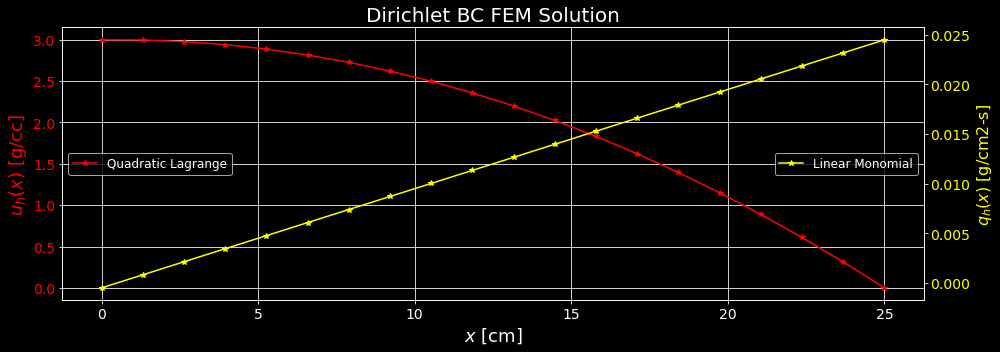

In [24]:
'''Show FEM Solution'''

import pandas as pd
df = pd.read_csv('output_x-data_0002.csv')

plot_solution(df, title='Dirichlet BC FEM Solution', basis_functions_type='Quadratic Lagrange', flux_basis_functions_type='Linear Monomial')

#### [Compute Error](#toc)<a id="difffluxerror1"></a>


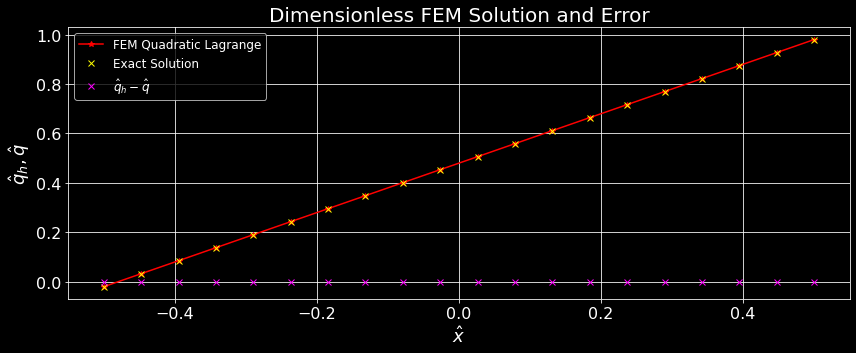

In [25]:
'''Flux Error Compared to Exact Dimensionless Solution'''

plot_flux_error(df, fem_type='FEM Quadratic Lagrange')

### [Code a Diffusion Flux Auxiliary Kernel](#toc)<a id="auxdiffflux2"></a>

An alternative way to compute the flux of $u$ is to program an auxiliary kernel. This is a worthwhile investment for learning how to implement an auxiliary kernel; in the future when the flux will be needed as a vector quantity, this learning experience will be leveraged.

1. `cd include`
1. `mkdir auxkernels`
1. `cd auxkernels`
1. Create a `DiffusionFluxComponent.h` class interface as folows:
 + Use the `FluxComponent.h` [course template](https://github.com/dpploy/engy-5310/blob/main/moose-app-templates/FluxComponent.h) as follows:
 + `cp *path-to*/moose-app-templates/FluxComponent.h .`
 + `mv FluxComponent.h DiffusionFluxComponent.h`
 + Edit the file `DiffusionFluxComponent.h` with a text editor by replacing all instances of `FluxComponent` with `DiffusionFluxComponent`.
1. `cd ../..`
1. `cd src`
1. `mkdir auxkernels`
1. `cd auxkernels`
1. Create a `DiffusionFluxComponent.C` class implementation as follows:
 + Use the `FluxComponent.C` [course template](https://github.com/dpploy/engy-5310/blob/main/moose-app-templates/FluxComponent.C) as follows.
 + `cp *path-to*/moose-app-templates/FluxComponent.C .`
 + `mv FluxComponent.C DiffusionFluxComponent.C`
 + Edit the file `DiffusionFluxComponent.C` with a text editor by replacing all instances of `FluxComponent` with `DiffusionFluxComponent`.
 + You will need to program the *computeValue()* method. <span style="color:red">This portion of the implementation is convered in class.</span>
 
Depending on your implementation, the `MOOSE` input block may look like this:

```
[AuxKernels]
  [diffusion-flux-x]
    execute_on = timestep_end
    type = DiffusionFluxComponent       # user-built auxiliary kernel
    field = u                           # user-defined parameter
    diffCoeff = ${replace diff_coeff}   # user-defined parameter
    component = x                       # user-defined parameter
    variable = diffFluxU_x              # produced quantity
  []
[]
```

### [Compile and Link Application](#toc)<a id="compile2"></a>

1. Make sure you are in the problem project directory:
 + `pwd`
1. You should see: `..../engy5310p1`
1. Compile and link the application
 + `make`
1. If all is sucessfull you should see among other things in the screen output:
 + Linking Library `.../engy5310p1/lib/libengy5310p1-opt.la...`
 + Linking Executable `.../engy5310p1/engy5310p1-opt...`

In [26]:
'''FEM Solution'''

x_left = 0
x_right = 25
y_bottom = -x_right/4.0
y_top = -y_bottom

u_left = 3
u_right = 0

diff_coeff = 0.1
source_s = 1e-3

qn_bottom = 0 # no draining at the bottom boundary
qn_top = 0 # no draining at the top boundary

diff_coeff = 0.1
source_s = 1e-3

n_felem_x = 3
n_felem_y = 2

from engy_5310.toolkit import write_engy5310_p1_2d_input_file

write_engy5310_p1_2d_input_file(x_left, x_right, y_bottom=y_bottom, y_top=y_top,
                                u_left=u_left, u_right=u_right,
                                diff_coeff=diff_coeff, source_s=source_s, n_felem_x=n_felem_x, n_felem_y=n_felem_y,
                                order=order,
                                n_plot_pts=n_plot_pts, compute_diffusion_flux=True, use_moose_diffusion_flux=False)

In [27]:
'''Display MOOSE input file created'''

!cat engy5310p1/input.hit

# Engy-5310 Problem: Poisson 2D FEM
# UMass Lowell Nuclear Chemical Engineering
# Prof. Valmor F. de Almeida
# 05Apr21 11:28:35

# Parameters
xmin = 0.00000e+00
xmax = 2.50000e+01
ymin = -6.25000e+00
ymax = 6.25000e+00
diff_coeff = 1.00000e-01
source_s = 1.00000e-03

[Problem]
type = FEProblem
coord_type = XYZ
[]

[Mesh]
  [2d]
    type = GeneratedMeshGenerator
    dim = 2
    xmin = ${replace xmin}
    xmax = ${replace xmax}
    ymin = ${replace ymin}
    ymax = ${replace ymax}
    nx = 3
    ny = 2
    elem_type = QUAD9
  []
[]

[Variables]
  [u]
    order = second
    family = lagrange
  []
[]

[AuxVariables]
  [diffFluxU]
    order = FIRST
    family = MONOMIAL_VEC
  []
  [diffFluxU_x]
    order = FIRST
    family = MONOMIAL
  []
  [diffFluxU_y]
    order = FIRST
    family = MONOMIAL
  []
[]

[Kernels]
  [diffusion-term]
    type = DiffusionTerm
    variable = u     # produced quantity
    diffCoeff = ${replace diff_coeff}
  []
  [source-term]
    type = SourceTerm
    variable = 

In [28]:
'''Run Engy5310P1 MOOSE App'''

!engy5310p1/engy5310p1-opt -i engy5310p1/input.hit



Framework Information:
MOOSE Version:           git commit e55311bc98 on 2021-04-01
LibMesh Version:         ed76100f41840c34c146dd0a7f1ff5410370b489
PETSc Version:           3.14.5
SLEPc Version:           3.14.2
Current Time:            Mon Apr  5 11:28:38 2021
Executable Timestamp:    Wed May  5 04:04:13 2021

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          2
  Spatial Dimension:       2
  Nodes:                   
    Total:                 35
    Local:                 35
  Elems:                   
    Total:                 6
    Local:                 6
  Num Subdomains:          1
  Num Partitions:          1

Nonlinear System:
  Num DOFs:                35
  Num Local DOFs:          35
  Variables:               "u" 
  Finite Element Types:    "LAGRANGE" 
  Approximation Orders:    "SECOND" 

Auxiliary System:
  Num DOFs:                72
  Num Local DOFs:          72
  Variable

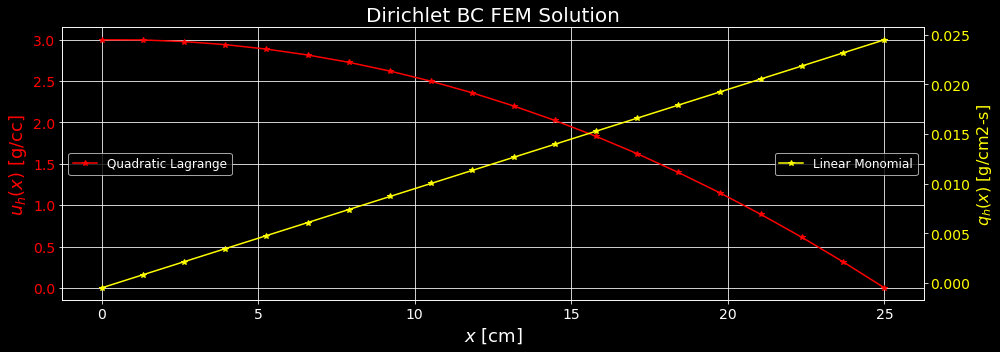

In [29]:
'''Show FEM Solution'''

import pandas as pd
df = pd.read_csv('output_x-data_0002.csv')

plot_solution(df, title='Dirichlet BC FEM Solution', basis_functions_type='Quadratic Lagrange', flux_basis_functions_type='Linear Monomial')

#### [Compute Error](#toc)<a id="difffluxerror2"></a>

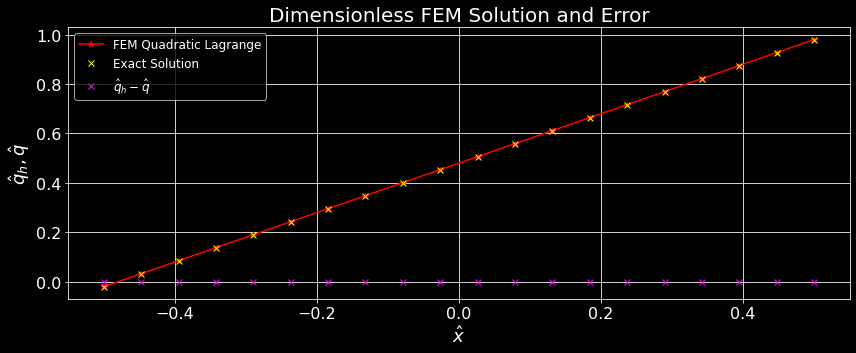

In [30]:
'''Error Compared to Exact Dimensionless Solution'''

plot_flux_error(df, fem_type='FEM Quadratic Lagrange')

## [Energy Postprocessing](#toc)<a id="energypostpro"></a>

To compute the [Dirichlet energy](#energy) a *Postprocessor* needs to be built. The user-developed class should use the previously computed diffusion flux component. With an eye towards the future use of this application in 2D and 3D, call this new class, `BulkEnergy`.

### [Code the Energy Postprocessor](#toc)<a id="postpro"></a>

1. `cd include`
1. `mkdir postprocessors`
1. `cd postprocessors`
1. Create a `BulkEnergy.h` class interface as folows:
 + Use the `ScalarVariableIntegralPostprocessor.h` [course template](https://github.com/dpploy/engy-5310/blob/main/moose-app-templates/ScalarVariableIntegralPostprocessor.h) as follows:
 + `cp *path-to*/moose-app-templates/ScalarVariableIntegralPostprocessor.h .`
 + `mv ScalarVariableIntegralPostprocessor.h BulkEnergy.h`
 + Edit the file `BulkEnergy.h` with a text editor by replacing all instances of `ScalarVariableIntegralPostprocessor` with `BulkEnergy`.
1. `cd ../..`
1. `cd src`
1. `mkdir postprocessors`
1. `cd postprocessors`
1. Create a `BulkEnergy.C` class implementation as follows:
 + Use the `ScalarVariableIntegralPostprocessor.C` [course template](https://github.com/dpploy/engy-5310/blob/main/moose-app-templates/ScalarVariableIntegralPostprocessor.C) as follows.
 + `cp *path-to*/moose-app-templates/ScalarVariableIntegralPostprocessor.C .`
 + `mv ScalarVariableIntegralPostprocessor.C BulkEnergy.C`
 + Edit the file `BulkEnergy.C` with a text editor by replacing all instances of `ScalarVariableIntegralPostprocessor` with `BulkEnergy`.
 + You will need to program the *computeValue()* method. See the example below for the input file *Postprocessor* block and the parameters needed. <span style="color:red">This portion of the implementation is convered in class.</span>

### [Compile and Link Application](#toc)<a id="compilelink2"></a>

1. Make sure you are in the problem project directory:
 + `pwd`
1. You should see: `..../engy5310p1`
1. Compile and link the application
 + `make`
1. If all is sucessfull you should see among other things in the screen output:
 + Linking Library `.../engy5310p1/lib/libengy5310p1-opt.la...`
 + Linking Executable `.../engy5310p1/engy5310p1-opt...`

### [Input File](#toc)<a id="energyinput"></a>

A new *Postprocessors* block should be created; an example follows:

```
[Postprocessors]
  [bulk-energy]
    type = BulkEnergy                                    # user-defined
    execute_on = 'timestep_end final'
    variable = 'u'     # bulk energy unknown variable    # user-defined 
    flux_component = 'diffFluxU_x'                       # user-defined
    diffCoeff = ${replace diff_coeff}                    # user-defined
    sourceS = ${replace source_s}                        # user-defined
  []
[]
```

### [Run Application](#toc)<a id="runenergy"></a>

Using an updated input file (see below) run the application as follows:
1. In the `engy5310p1/` directory run the application with the Linux shell command:
 + `./engy5310p1-opt -i input.hit`
2. Compare your results with this notebook results below.
3. Return here to follow instructions on how to implement the calculation of the total energy.

## [Energy Results](#toc)<a id="energyresults"></a>

In [31]:
'''FEM Solution'''

x_left = 0
x_right = 25
y_bottom = -x_right/4.0
y_top = -y_bottom

u_left = 3
u_right = 0

diff_coeff = 0.1
source_s = 1e-3

qn_bottom = 0 # no draining at the bottom boundary
qn_top = 0 # no draining at the top boundary

diff_coeff = 0.1
source_s = 1e-3

n_felem_x = 3
n_felem_y = 2

order = 'second'
#n_plot_pts = 2*n_felem + 1
n_plot_pts = 20

from engy_5310.toolkit import write_engy5310_p1_2d_input_file

write_engy5310_p1_2d_input_file(x_left, x_right, y_bottom=y_bottom, y_top=y_top, 
                                u_left=u_left, u_right=u_right, 
                                diff_coeff=diff_coeff, source_s=source_s, n_felem_x=n_felem_x, n_felem_y=n_felem_y, 
                                order=order, 
                                n_plot_pts=n_plot_pts,
                                compute_diffusion_flux=True)

In [32]:
'''Display MOOSE input file created'''

!cat engy5310p1/input.hit

# Engy-5310 Problem: Poisson 2D FEM
# UMass Lowell Nuclear Chemical Engineering
# Prof. Valmor F. de Almeida
# 05Apr21 11:29:00

# Parameters
xmin = 0.00000e+00
xmax = 2.50000e+01
ymin = -6.25000e+00
ymax = 6.25000e+00
diff_coeff = 1.00000e-01
source_s = 1.00000e-03

[Problem]
type = FEProblem
coord_type = XYZ
[]

[Mesh]
  [2d]
    type = GeneratedMeshGenerator
    dim = 2
    xmin = ${replace xmin}
    xmax = ${replace xmax}
    ymin = ${replace ymin}
    ymax = ${replace ymax}
    nx = 3
    ny = 2
    elem_type = QUAD9
  []
[]

[Variables]
  [u]
    order = second
    family = lagrange
  []
[]

[AuxVariables]
  [diffFluxU]
    order = FIRST
    family = MONOMIAL_VEC
  []
  [diffFluxU_x]
    order = FIRST
    family = MONOMIAL
  []
  [diffFluxU_y]
    order = FIRST
    family = MONOMIAL
  []
[]

[Kernels]
  [diffusion-term]
    type = DiffusionTerm
    variable = u     # produced quantity
    diffCoeff = ${replace diff_coeff}
  []
  [source-term]
    type = SourceTerm
    variable = 

In [33]:
'''Run Engy5310P1 MOOSE App'''

!engy5310p1/engy5310p1-opt -i engy5310p1/input.hit



Framework Information:
MOOSE Version:           git commit e55311bc98 on 2021-04-01
LibMesh Version:         ed76100f41840c34c146dd0a7f1ff5410370b489
PETSc Version:           3.14.5
SLEPc Version:           3.14.2
Current Time:            Mon Apr  5 11:29:04 2021
Executable Timestamp:    Wed May  5 04:04:13 2021

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          2
  Spatial Dimension:       2
  Nodes:                   
    Total:                 35
    Local:                 35
  Elems:                   
    Total:                 6
    Local:                 6
  Num Subdomains:          1
  Num Partitions:          1

Nonlinear System:
  Num DOFs:                35
  Num Local DOFs:          35
  Variables:               "u" 
  Finite Element Types:    "LAGRANGE" 
  Approximation Orders:    "SECOND" 

Auxiliary System:
  Num DOFs:                72
  Num Local DOFs:          72
  Variable

#### [Compute Error](#toc)<a id="energyerror"></a>

In [34]:
import pandas as pd
df = pd.read_csv('output_energy.csv')

fem_energy = df['bulk-energy'][0]

L = x_right - x_left

fem_energy_hat = fem_energy/(y_top-y_bottom)/source_s**2/L**3
print('FEM energy   [] = %10.6e'%(fem_energy_hat))

from engy_5310.toolkit import engy5310_p1_exact_solution

(_, _, energy_hat) = engy5310_p1_exact_solution(x_left, x_right, u_left, u_right, diff_coeff, source_s)

print('Exact energy [] = %10.6e'%(energy_hat))

print('Energy rel. error [%%] = %10.3e'%((fem_energy_hat-energy_hat)/energy_hat*100))

FEM energy   [] = -1.664667e-01
Exact energy [] = -1.664667e-01
Energy rel. error [%] = -1.000e-12


## [Application Tree](#toc)<a id="tree"></a>

This tree printout helps the understanding of various pieces of the `MOOSE` application repository created after all the above steps including future implementations in the notebooks following the present one that cover various boundary conditions.

In [35]:
!tree engy5310p1

engy5310p1
├── LICENSE
├── Makefile
├── README.md
├── __pycache__
│   └── chigger.cpython-38.pyc
├── build
│   ├── header_symlinks
│   │   ├── BoundaryEnergy.h -> /home/dealmeida/OneDrive/uml-courses/engy-5310/2021-01-05-spring/jupynb-repo/notebooks/engy5310p1/include/postprocessors/BoundaryEnergy.h
│   │   ├── BulkEnergy.h -> /home/dealmeida/OneDrive/uml-courses/engy-5310/2021-01-05-spring/jupynb-repo/notebooks/engy5310p1/include/postprocessors/BulkEnergy.h
│   │   ├── DiffusionFlux.h -> /home/dealmeida/OneDrive/uml-courses/engy-5310/2021-01-05-spring/jupynb-repo/notebooks/engy5310p1/include/auxkernels/DiffusionFlux.h
│   │   ├── DiffusionFluxComponent.h -> /home/dealmeida/OneDrive/uml-courses/engy-5310/2021-01-05-spring/jupynb-repo/notebooks/engy5310p1/include/auxkernels/DiffusionFluxComponent.h
│   │   ├── DiffusionTerm.h -> /home/dealmeida/OneDrive/uml-courses/engy-5310/2021-01-05-spring/jupynb-repo/notebooks/engy5310p1/include/kernels/DiffusionTerm.h
│   │   ├── Engy5310P1App.h ->